# Семинар 1: Цветовые пространства

На этом семинаре мы познакомимся с различными цветовыми моделями и научимся преобразовывать изображения между ними.

**Цели занятия:**

- понять различия между RGB, HSV, CMYK и Lab;
- научиться преобразовывать изображения между цветовыми пространствами с помощью OpenCV;
- научиться визуализировать отдельные цветовые каналы;
- выполнить маскирование по диапазону оттенков в пространстве HSV.

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Вспомогательная функция для отображения нескольких изображений в строку
def show_images(images, titles=None, cols=3, figsize=(32,16), cmap=None, font_size=12):
    """Отображает несколько изображений с возможностью настройки размера шрифта для заголовков."""
    rows = (len(images) + cols - 1) // cols
    plt.figure(figsize=figsize)
    for i, img in enumerate(images):
        plt.subplot(rows, cols, i+1)
        if img.ndim == 2:
            plt.imshow(img, cmap=cmap or 'gray')
        else:
            # cv2 читает изображения в формате BGR; для отображения переводим в RGB
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if titles and i < len(titles):
            plt.title(titles[i], fontsize=font_size)  # ← Новый параметр font_size
        plt.axis('off')
    plt.tight_layout()
    plt.show()

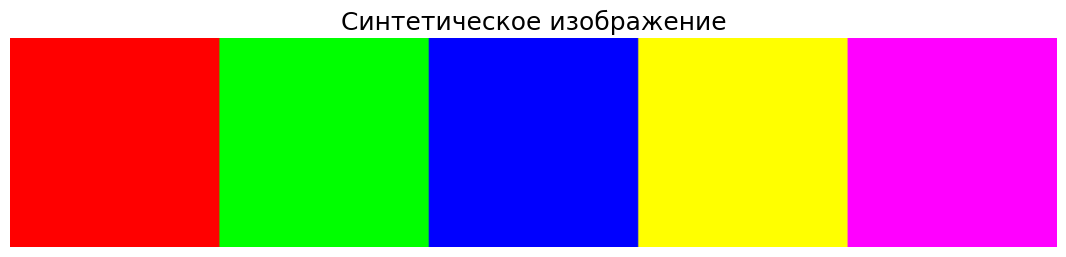

In [26]:
# Создадим синтетическое изображение с пятью цветными полосами
height, width = 100, 500
img = np.zeros((height, width, 3), dtype=np.uint8)
# красный, зелёный, синий, жёлтый, пурпурный
colors = [ (0,0,255), (0,255,0), (255,0,0), (0,255,255), (255,0,255) ]
for i, color in enumerate(colors):
    img[:, i*width//len(colors):(i+1)*width//len(colors)] = color

show_images([img], ['Синтетическое изображение'], font_size=18)

## Преобразование RGB → HSV

Цветовое пространство HSV (Hue–Saturation–Value) удобно для анализа изображения по оттенкам и яркости. 

В OpenCV имеется функция `cv2.cvtColor` для конвертации из BGR в HSV. 

Оттенок `H` измеряется в градусах 0–179 (в OpenCV). Насыщенность `S` и яркость `V` — от 0 до 255.


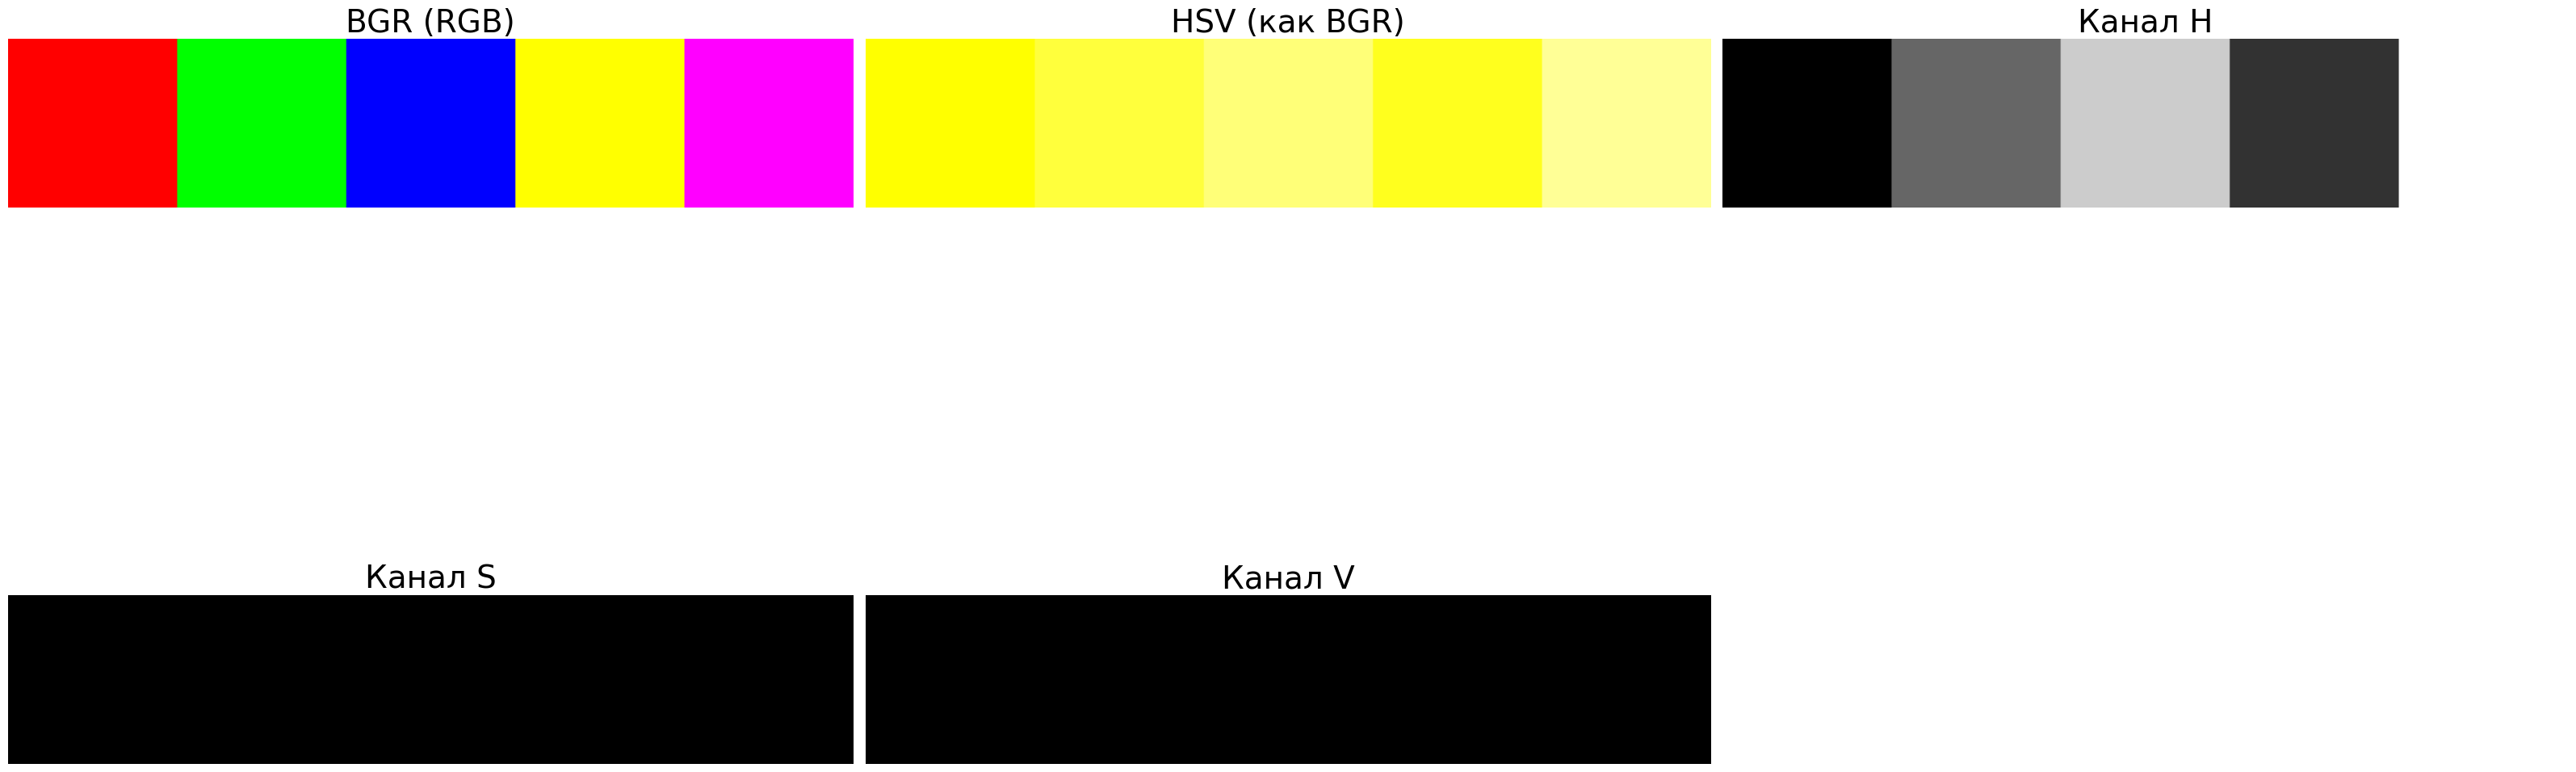

In [29]:
# Переведём изображение из BGR в HSV
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
# Разделим на три канала
h_channel, s_channel, v_channel = cv2.split(hsv)
# Для отображения оттенка отмасштабируем H до 0–255
h_vis = (h_channel.astype(np.float32) * 255/179).astype(np.uint8)
show_images([img, hsv, h_vis, s_channel, v_channel],
            ['BGR (RGB)', 'HSV (как BGR)', 'Канал H', 'Канал S', 'Канал V'],
            cols=3, font_size=28) 

## Преобразование RGB → CMYK

Модель CMYK — субтрактивная; она используется в печати. В OpenCV нет готовой функции для перевода, поэтому реализуем собственную. 

Формулы:
\begin{align*}
C &= 1 - R,\\
M &= 1 - G,\\
Y &= 1 - B,\\
K &= \min(C, M, Y),\\
C' &= \frac{C-K}{1-K},\\
M' &= \frac{M-K}{1-K},\\
Y' &= \frac{Y-K}{1-K}.
\end{align*}


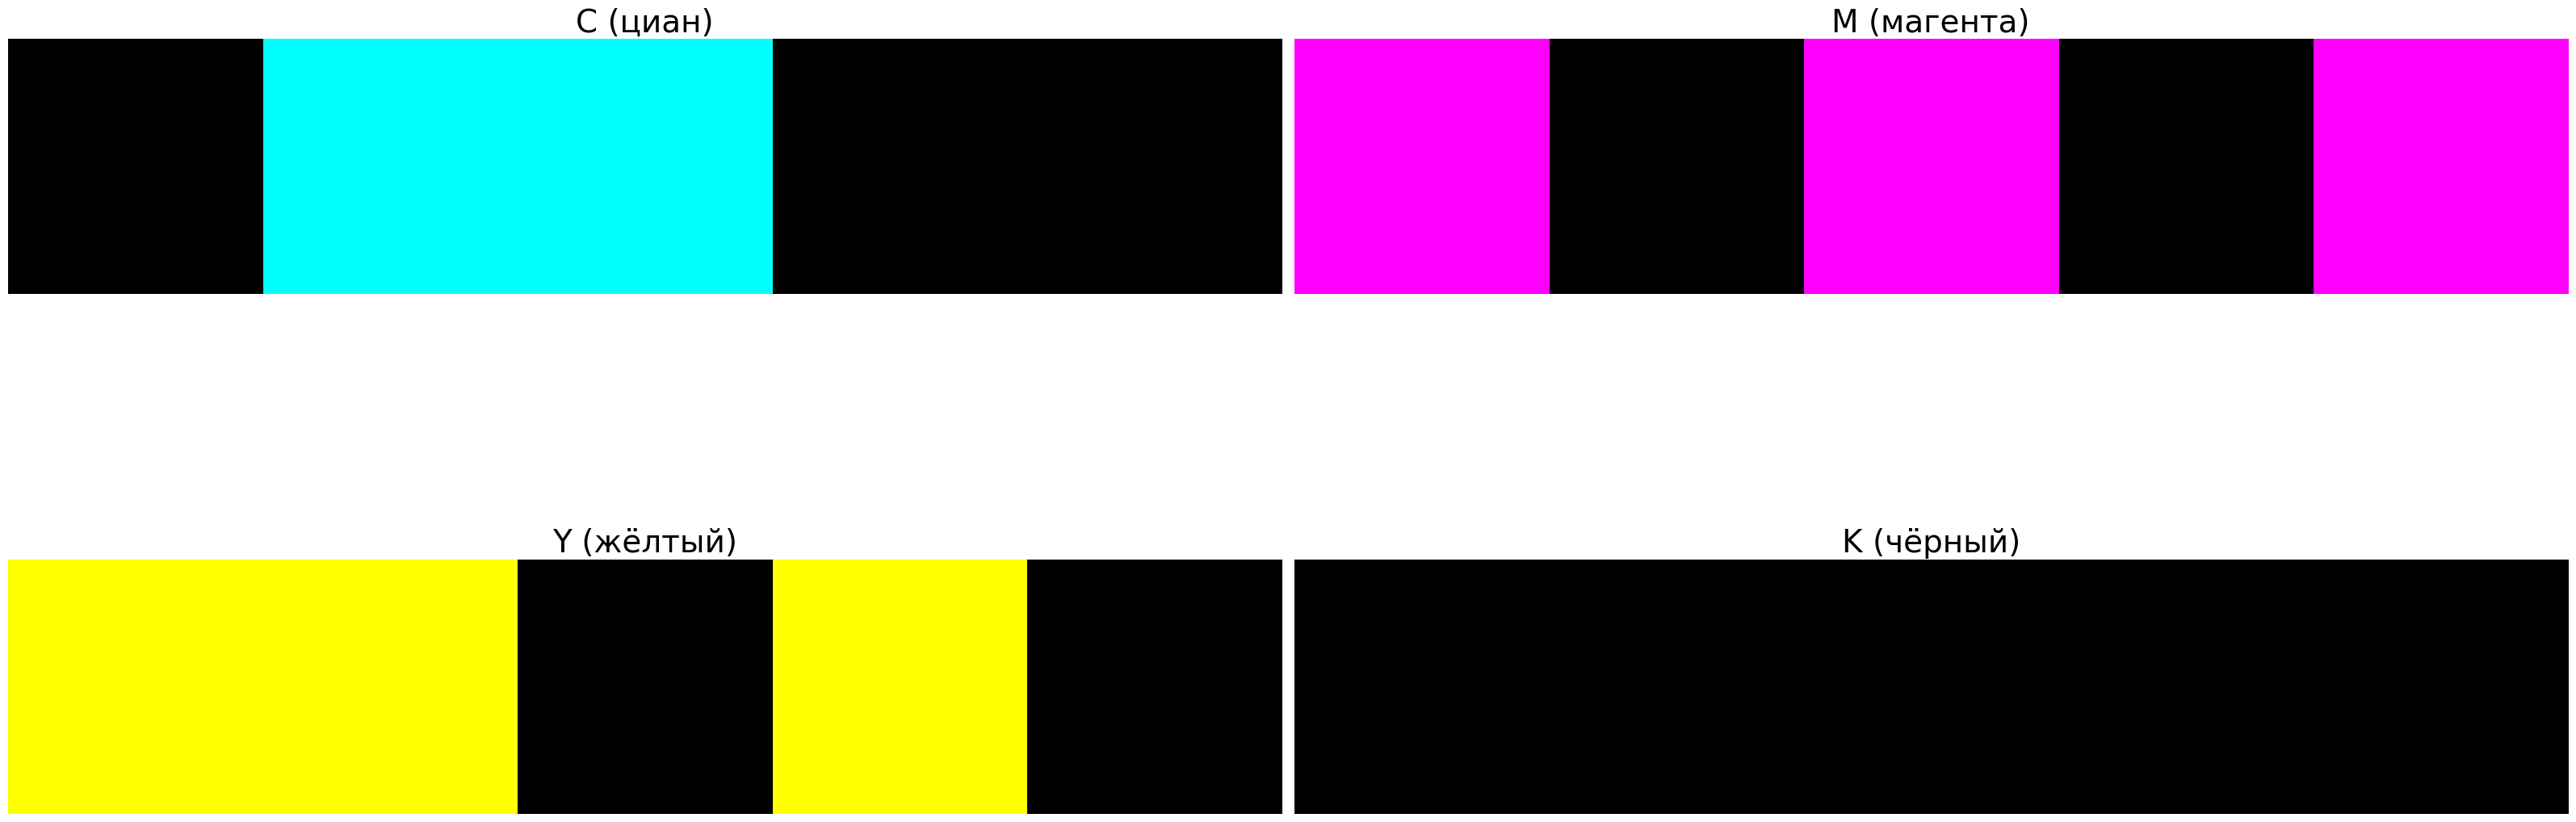

In [36]:
# Функция перевода BGR -> CMYK
def bgr2cmyk(img):
    # Преобразование BGR → CMYK, нормирование и получение каналов
    bgr = img.astype(np.float32) / 255.0
    b, g, r = cv2.split(bgr)
    C = 1 - r; M = 1 - g; Y = 1 - b
    K = np.minimum(np.minimum(C, M), Y)
    K[K == 1] = 0
    C_c = (C - K) / (1 - K + 1e-8)
    M_c = (M - K) / (1 - K + 1e-8)
    Y_c = (Y - K) / (1 - K + 1e-8)

    # Преобразуем в 8‑бит и визуализируем как цветные изображения
    C_u, M_u, Y_u, K_u = (C_c*255).astype(np.uint8), (M_c*255).astype(np.uint8), (Y_c*255).astype(np.uint8), (K*255).astype(np.uint8)
    cyan_img    = cv2.merge([C_u, C_u, np.zeros_like(C_u)])      # голубой: B=C, G=C, R=0
    magenta_img = cv2.merge([M_u, np.zeros_like(M_u), M_u])      # пурпурный: B=M, G=0, R=M
    yellow_img  = cv2.merge([np.zeros_like(Y_u), Y_u, Y_u])      # жёлтый: B=0, G=Y, R=Y
    black_img   = cv2.merge([K_u, K_u, K_u])                     # чёрный

    return cyan_img, magenta_img, yellow_img, black_img

C, M_, Y, K = bgr2cmyk(img)

#print(C[0, :], M_[0, :], Y[0, :], K[0, :])
show_images([C, M_, Y, K], ['C (циан)', 'M (магентa)', 'Y (жёлтый)', 'K (чёрный)'], cols=2, cmap='gray', font_size=28)

## Преобразование RGB → Lab

Модель Lab описывает цвет тремя координатами: 

    - L* — светлота, 
    - a* — оттенок от зелёного к красному, 
    - b* — оттенок от синего к жёлтому. Она близка к восприятию человека и независима от устройства. 

В OpenCV она называется `cv2.COLOR_BGR2Lab`.


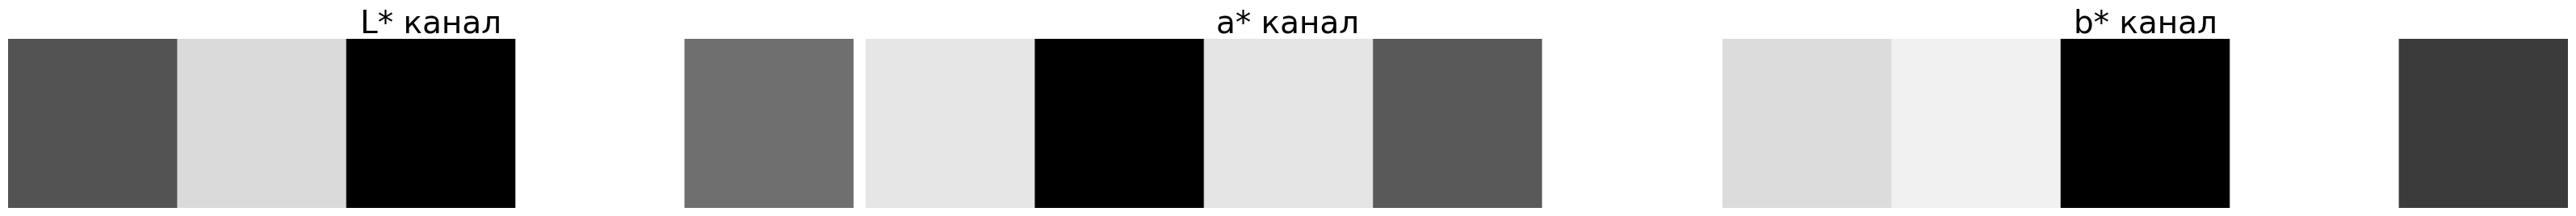

In [31]:
# Переведём изображение в Lab и визуализируем каналы
lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
L, a, b_ = cv2.split(lab)
show_images([L, a, b_], ['L* канал', 'a* канал', 'b* канал'], cols=3, cmap='gray', font_size=28)

## Маскирование по оттенку в HSV

Как пример практического применения HSV, выделим все пиксели с красным оттенком. 

В HSV красный расположен в двух областях: около 0° и около 180°. Мы создадим две маски и объединим их.


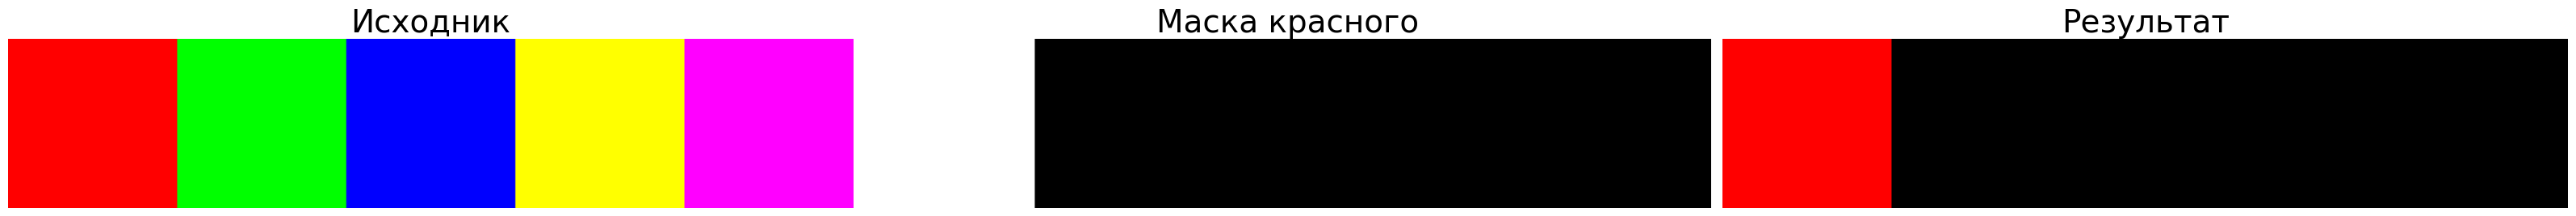

In [32]:
# Создадим маску для красного цвета
# Диапазоны оттенка для красного
low_red1 = np.array([0, 150, 100])
high_red1 = np.array([10, 255, 255])
low_red2 = np.array([160, 150, 100])
high_red2 = np.array([179, 255, 255])
mask1 = cv2.inRange(hsv, low_red1, high_red1)
mask2 = cv2.inRange(hsv, low_red2, high_red2)
mask = cv2.bitwise_or(mask1, mask2)
# Применим маску
res = cv2.bitwise_and(img, img, mask=mask)
show_images([img, mask, res], ['Исходник', 'Маска красного', 'Результат'], font_size=28)

## Итоги

* На семинаре мы рассмотрели различные цветовые пространства и научились переводить изображения из одного пространства в другое.
* HSV удобен для сегментации по оттенку; Lab — более близок к человеческому восприятию; CMYK используется в печати.
* Дополнительная практика: поэкспериментируйте с другими изображениями, попробуйте выделить зелёные и синие области, постройте гистограммы по каждому каналу.